# Plots for RRI Experiments near Ottawa 18-22 April 2016
May 3rd 2017
David Fairbairn

This document is an implementation in workbook format of many plotting functions which I've already written. Some logical separation of files was necessary for other reasons ipython workbooks would be a more appropriate format for doing plotting and tweaking parameters.

In [6]:
# Built-in Python dependencies
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
from datetime import datetime as dt
# Some DaVitPy dependencies
from davitpy.utils import plotUtils
from davitpy.models import aacgm
from davitpy.models import igrf
# Some of my own analytical utilities
from data_utils import *
from script_utils import *

## Plotting An ePOP Pass
The first and most common or simple plot: ground tracks of ePOP passes.

In [28]:
def plot_ottawa_ephem(date_string):
    """
    Put the plotting procedure for looking at satellite ephemeris vs. Ottawa
    transmitter into a function.

    Note that the transmitter is a Barker & Williamson Model 110.

    **PARAMS**
    geog_longs
    geog_lats
    alts
    ephemtimes
    date_string (String): String in the format of "20160418"

    *** RETURNS ***
    - (Just plots)

    """
    # TODO: fixup this documentation
    if isinstance(date_string, type(None)): date_string="20160418"
       
    fname,index_reversal = get_ottawa_data(date_string)
    geog_longs,geog_lats,alts,ephemtimes = get_rri_ephemeris(fname)

    # Location of Ottawa: I looked it up and hard-coded it at the top
    times = ephems_to_datetime(ephemtimes)

    indx_shortest, dists = get_closest_ottawa_approach(geog_longs, geog_lats, alts)
    appr_time = times[indx_shortest]
    
    # The numeric data type that I was retrieving from geog_longs, when _NOT_ stored
    # in an array, was being rejected by the mapObj() function below. So I convert 
    # these numbers to floats explicitly here.
    shortest_ephem_long = float(geog_longs[indx_shortest])
    shortest_ephem_lat = float(geog_lats[indx_shortest])
    inversion_ephem_long = float(geog_longs[index_reversal])
    inversion_ephem_lat = float(geog_lats[index_reversal])
    
    # A different font for the legend etc. might be nice
    #fig = plt.figure()
    font = {'fontname':'Computer Modern'}
    m = plotUtils.mapObj(lat_0=45.0, lon_0=-75.0, width=111e3*180, height=111e3*90, coords='geo',datetime=times[0])
    
    # FIRST: Plot the location of Ottawa
    x,y = m(OTTAWA_TX_LON,OTTAWA_TX_LAT,coords='geo')
    m.plot(x,y,'r-o',markersize=9,label="Ottawa")
    
    # SECOND: Plot the satellite ground-track.
    x,y = m(geog_longs, geog_lats, coords='geo')
    m.plot(x,y,'b',label="EPOP ground track")
    
    # THIRD: Plot a circle emphasizing the point of closest approach
    x,y = m(shortest_ephem_long,shortest_ephem_lat, coords='geo')
    m.plot(x,y,'bo',label=("Closest Approach at " + str(appr_time)))
    
    # FOURTH: Plot the line from Ottawa to the nearest approach of the satellite.
    x,y = m([shortest_ephem_long, OTTAWA_TX_LON], [shortest_ephem_lat, OTTAWA_TX_LAT], coords='geo')
    m.plot(x,y,'g')
    
    # FIFTH: Plot the piont I've determined is the point of the Faraday Rotation inversion.
    x,y = m(inversion_ephem_long,inversion_ephem_lat,coords='geo')
    m.plot(x,y,'yo',label=("Inflection of Faraday Rotation"))
    
    # SIXTH: a few lines of magnetic longitude and latitude will be plotted as well.
   
    N = 10
    latdivs = 90./N
    londivs = 360./N
    for n in range(N):
        merid_mlat = np.arange(181) - 90.
        merid_mlon = merid_mlat*0 - n*londivs
        paral_mlon = np.arange(361) - 180.
        paral_mlat = paral_mlon*0. + n*latdivs
        x,y = m(merid_mlon, merid_mlat, coords='mag')
        m.plot(x,y,'k')#,label="Line of Magnetic Longitude of -20 Degrees")
        x,y = m(paral_mlon, paral_mlat, coords='mag')
        m.plot(x,y,'k')#,label="Line of Magnetic Latitude of +75 Degrees")
    
    # SEVENTH: GET IGRF DATA FOR EACH EPHEMERIS POINT
    """
    itype = 1 #Geodetic coordinates
    pyDate = times[0] # The first time we pull from the RRI file
    date = utils.dateToDecYear(pyDate) # decimal year
    alt = 300. # altitude #TODO: grab altitudes for series of satellite positions we care about.
    stp = 1. #
    xlti, xltf, xltd = OTTAWA_TX_LAT, OTTAWA_TX_LAT,stp # latitude start, stop, step
    xlni, xlnf, xlnd = OTTAWA_TX_LON, OTTAWA_TX_LON,stp # longitude start, stop, step
    ifl = 0 # Main field
    # Call fortran subroutine
    lat,lon,d,s,h,x,y,z,f = igrf.igrf11(itype,date,alt,ifl,xlti,xltf,xltd,xlni,xlnf,xlnd)
    """

    my_xticks = []
    num_ticks = 5
    length = times.__len__()
    tick_sep = length/(num_ticks - 1)
    alt_t = alts[0]
    lon_t = geog_longs[0]
    lat_t = geog_lats[0]
    dt_t  = times[0]
    my_xticks.append("Altitude:    "+str(alt_t)+"\nLatitude:    "+str(lat_t)+"\nLongitude:    "+str(lon_t)+"\nTime (UTC):    "+str(dt_t))
    for i in range(num_ticks-1):
        alt_t = alts[tick_sep*(i+1)]
        lon_t = geog_longs[tick_sep*(i+1)]
        lat_t = geog_lats[tick_sep*(i+1)]
        dt_t  = times[tick_sep*(i+1)]
        my_xticks.append(str(alt_t)+"\n"+str(lat_t)+"\n"+str(lon_t)+"\n"+str(dt_t))

    plt.xlabel('Geographic Longitude (degrees)')
    plt.ylabel('Geographic Latitude (degrees)')
    plt.title("EPOP Closest Approach vs. Ottawa radar for " + "2016-04-" + str(times[0].day))
    #plt.legend(loc='best')
    plt.show()
    
plot_ottawa_ephem("20160418")

AttributeError: 'AxesSubplot' object has no attribute 'get_facecolor'

## Plotting All 5 Ottawa Passes From April 2016 
For the April 2016 RRI experiments, figures have been produced and tweaked which show each of the five passes over Ottawa. The RRI analysis tools are used in order to plot 

In [8]:
from ottawa_plots import *
def plot_all5():
    """
    Plot April 18th-22nd ephemeris tracks on same mapobj
    """
    fname_18th, idx_rev_18th, ellip_rev_18th = get_ottawa_data2("20160418")
    lons_18th, lats_18th, alts_18th, ephtimes_18th = get_rri_ephemeris(fname_18th)
    fname_19th, idx_rev_19th, ellip_rev_19th = get_ottawa_data2("20160419")
    lons_19th, lats_19th, alts_19th, ephtimes_19th = get_rri_ephemeris(fname_19th)
    fname_20th, idx_rev_20th, ellip_rev_20th = get_ottawa_data2("20160420")
    lons_20th, lats_20th, alts_20th, ephtimes_20th = get_rri_ephemeris(fname_20th)
    fname_21st, idx_rev_21st, ellip_rev_21st = get_ottawa_data2("20160421")
    lons_21st, lats_21st, alts_21st, ephtimes_21st = get_rri_ephemeris(fname_21st)
    fname_22nd, idx_rev_22nd, ellip_rev_22nd = get_ottawa_data2("20160422")
    lons_22nd, lats_22nd, alts_22nd, ephtimes_22nd = get_rri_ephemeris(fname_22nd)
    
    times_18th = ephems_to_datetime(ephtimes_18th)
    times_19th = ephems_to_datetime(ephtimes_19th)
    times_20th = ephems_to_datetime(ephtimes_20th)
    times_21st = ephems_to_datetime(ephtimes_21st)
    times_22nd = ephems_to_datetime(ephtimes_22nd)

    indx_shortest_18th, dists_18th = get_closest_ottawa_approach(lons_18th, lats_18th, alts_18th)
    indx_shortest_19th, dists_19th = get_closest_ottawa_approach(lons_19th, lats_19th, alts_19th)
    indx_shortest_20th, dists_20th = get_closest_ottawa_approach(lons_20th, lats_20th, alts_20th)
    indx_shortest_21st, dists_21st = get_closest_ottawa_approach(lons_21st, lats_21st, alts_21st)
    indx_shortest_22nd, dists_22nd = get_closest_ottawa_approach(lons_22nd, lats_22nd, alts_22nd)
    
    # The numeric data type that I was retrieving from geog_longs, when _NOT_ stored
    # in an array, was being rejected by the mapObj() function below. So I convert 
    # these numbers to floats explicitly here.
    shlon_18th = float(lons_18th[indx_shortest_18th])
    shlat_18th = float(lats_18th[indx_shortest_18th])
    invlon_18th = float(lons_18th[idx_rev_18th])
    invlat_18th = float(lats_18th[idx_rev_18th])
    elliplon_18th = float(lons_18th[ellip_rev_18th])
    elliplat_18th = float(lats_18th[ellip_rev_18th])
 
    shlon_19th = float(lons_19th[indx_shortest_19th])
    shlat_19th = float(lats_19th[indx_shortest_19th])
    invlon_19th = float(lons_19th[idx_rev_19th])
    invlat_19th = float(lats_19th[idx_rev_19th])
    elliplon_19th = float(lons_19th[ellip_rev_19th])
    elliplat_19th = float(lats_19th[ellip_rev_19th])

    shlon_20th = float(lons_20th[indx_shortest_20th])
    shlat_20th = float(lats_20th[indx_shortest_20th])
    invlon_20th = float(lons_20th[idx_rev_20th])
    invlat_20th = float(lats_20th[idx_rev_20th])
    elliplon_20th = float(lons_20th[ellip_rev_20th])
    elliplat_20th = float(lats_20th[ellip_rev_20th])

    shlon_21st = float(lons_21st[indx_shortest_21st])
    shlat_21st = float(lats_21st[indx_shortest_21st])
    invlon_21st = float(lons_21st[idx_rev_21st])
    invlat_21st = float(lats_21st[idx_rev_21st])
    elliplon_21st = float(lons_21st[ellip_rev_21st])
    elliplat_21st = float(lats_21st[ellip_rev_21st])

    shlon_22nd = float(lons_22nd[indx_shortest_22nd])
    shlat_22nd = float(lats_22nd[indx_shortest_22nd])
    invlon_22nd = float(lons_22nd[idx_rev_22nd])
    invlat_22nd = float(lats_22nd[idx_rev_22nd])
    elliplon_22nd = float(lons_22nd[ellip_rev_22nd])
    elliplat_22nd = float(lats_22nd[ellip_rev_22nd])
   
    # A different font for the legend etc. might be nice
    fig = plt.figure(1, figsize=(14,8))
    font = {'fontname':'Computer Modern'}
    #m = plotUtils.mapObj(lat_0=45.0, lon_0=-75.0, width=50e3*180, height=40e3*90, coords='geo',resolution='i',datetime=times_20th[0])
    m = plotUtils.mapObj(lat_0=57.0, lon_0=0.0, width=25e3*180, height=25e3*90, coords='mag',resolution='i',datetime=times_20th[0])

    # FIRST: Plot the location of Ottawa
    x,y = m(OTTAWA_TX_LON,OTTAWA_TX_LAT,coords='geo')
    m.plot(x,y,'r-o',markersize=9,label="Ottawa")
    
    # SECOND: Plot the satellite ground-track.
    x,y = m(lons_18th, lats_18th, coords='geo')
    m.plot(x,y,'b-',label="April 18th")#label="EPOP ground track")
    x,y = m(lons_19th, lats_19th, coords='geo')
    m.plot(x,y,'b:',label="April 19th")
    x,y = m(lons_20th, lats_20th, coords='geo')
    m.plot(x,y,'b--',label="April 20th")
    x,y = m(lons_21st, lats_21st, coords='geo')
    m.plot(x,y,'k-',label="April 21st")
    x,y = m(lons_22nd, lats_22nd, coords='geo')
    m.plot(x,y,'k:',label="April 22nd")
    
    # THIRD: Plot a circle emphasizing the point of closest approach
    x,y = m(shlon_18th, shlat_18th, coords='geo')
    m.plot(x,y,'bo',label='Closest Approach TX')
    x,y = m(shlon_19th, shlat_19th, coords='geo')
    m.plot(x,y,'bo')
    x,y = m(shlon_20th, shlat_20th, coords='geo')
    m.plot(x,y,'bo')
    x,y = m(shlon_21st, shlat_21st, coords='geo')
    m.plot(x,y,'bo')
    x,y = m(shlon_22nd, shlat_22nd, coords='geo')
    m.plot(x,y,'bo')

    # FOURTH: Plot the piont I've determined is the point of the Faraday Rotation inversion.
    x,y = m(invlon_18th, invlat_18th, coords='geo')
    m.plot(x,y,'yo',markersize=6,label=("Inflection of Faraday Rotation"))
    x,y = m(invlon_19th, invlat_19th, coords='geo')
    m.plot(x,y,'yo')
    x,y = m(invlon_20th, invlat_20th, coords='geo')
    m.plot(x,y,'yo')
    x,y = m(invlon_21st, invlat_21st, coords='geo')
    m.plot(x,y,'yo')
    x,y = m(invlon_22nd, invlat_22nd, coords='geo')
    m.plot(x,y,'yo')

    # FIFTH: Plot the point we've determined to be the ellipticity reversal
    x,y = m(elliplon_18th, elliplat_18th, coords='geo')
    m.plot(x,y,'go',markersize=4,label=("Inflection of Ellipticity Angle"))
    x,y = m(elliplon_19th, elliplat_19th, coords='geo')
    m.plot(x,y,'go',markersize=4)
    x,y = m(elliplon_20th, elliplat_20th, coords='geo')
    m.plot(x,y,'go',markersize=4)
    x,y = m(elliplon_21st, elliplat_21st, coords='geo')
    m.plot(x,y,'go',markersize=4)
    x,y = m(elliplon_22nd, elliplat_22nd, coords='geo')
    m.plot(x,y,'go',markersize=4)

    # FIFTH: a few lines of magnetic longitude and latitude will be plotted as well.
    #N = 10
    #latdivs = 90./N
    #londivs = 360./N
    #for n in range(N):
    #    merid_mlat = np.arange(181) - 90.
    #    merid_mlon = merid_mlat*0 - n*londivs
    #    paral_mlon = np.arange(361) - 180.
    #    paral_mlat = paral_mlon*0. + n*latdivs
    #    x,y = m(merid_mlon, merid_mlat, coords='mag')
    #    if n == 0:
    #        m.plot(x,y,'k',label="Magnetic Longitude and Latitude")
    #        continue
    #    m.plot(x,y,'k')#,label="Line of Magnetic Longitude of -20 Degrees")
    #    x,y = m(paral_mlon, paral_mlat, coords='mag')
    #    m.plot(x,y,'k')#,label="Line of Magnetic Latitude of +75 Degrees")
    ax = plt.gca()
    ax.set_xlabel('Magnetic Longitude (degrees)')
    ax.xaxis.set_label_coords(0.5,-0.050)
    #plt.xlabel('Magnetic Longitude (degrees)')
    plt.ylabel('Magnetic Latitude (degrees)')
    plt.title("ePOP Pass vs. Ottawa radar from April 18th - 22nd, 2016")
    plt.legend(loc='lower right', numpoints = 1)#loc='best')
    plt.savefig('tmp_all5.eps', format='eps', bbox_inches='tight')
    plt.savefig('tmp_all5.png', format='png', bbox_inches='tight')
    plt.show()
 
plot_all5()

AttributeError: 'AxesSubplot' object has no attribute 'get_facecolor'

## Plotting the Ottawa Passes from only the 18th and the 22nd
In the past it's been worth plotting not all 5 Ottawa passes, but just the first and the last.

In [ ]:
def plot_1822():
    """
    Plot April 18th and 22nd ephemeris tracks on same mapobj
    """
    # TODO: fixup this documentation
    date_string="20160418"
       
    fname,index_reversal,ellip_reversal = get_ottawa_data2(date_string)
    geog_longs,geog_lats,alts,ephemtimes = get_rri_ephemeris(fname)

    fname_22nd, idx_rev_22nd, ellip_reversal_22nd = get_ottawa_data2("20160422")
    lons_22nd, lats_22nd, alts_22nd, ephtimes_22nd = get_rri_ephemeris(fname_22nd)

    times = ephems_to_datetime(ephemtimes)
    times_22nd = ephems_to_datetime(ephtimes_22
In [ ]:
nd)

    indx_shortest, dists = get_closest_ottawa_approach(geog_longs, geog_lats, alts)
    appr_time = times[indx_shortest]

    indx_shortest_22nd, dists_22nd = get_closest_ottawa_approach(lons_22nd, lats_22nd, alts_22nd)
    appr_time_22nd = times_22nd[indx_shortest_22nd]
    
    # The numeric data type that I was retrieving from geog_longs, when _NOT_ stored
    # in an array, was being rejected by the mapObj() function below. So I convert 
    # these numbers to floats explicitly here.
    shortest_ephem_long = float(geog_longs[indx_shortest])
    shortest_ephem_lat = float(geog_lats[indx_shortest])
    inversion_ephem_long = float(geog_longs[index_reversal])
    inversion_ephem_lat = float(geog_lats[index_reversal])
    elliplon_18th = float(geog_longs[ellip_reversal])
    elliplat_18th = float(geog_lats[ellip_reversal])

    elliplon_22nd = float(lons_22nd[ellip_reversal_22nd])
    elliplat_22nd = float(lats_22nd[ellip_reversal_22nd])
    shlon_22nd = float(lons_22nd[indx_shortest])
    shlat_22nd = float(lats_22nd[indx_shortest])
    invlon_22nd = float(lons_22nd[index_reversal])
    invlat_22nd = float(lats_22nd[index_reversal])
    
    # A different font for the legend etc. might be nice
    fig = plt.figure(1, figsize=(14,8))
    font = {'fontname':'Computer Modern'}
    #m = plotUtils.mapObj(lat_0=45.0, lon_0=-75.0, width=60e3*180, height=50e3*90, coords='geo', resolution='i',datetime=times[0])
    m = plotUtils.mapObj(lat_0=57.0, lon_0=0.0, width=25e3*180, height=25e3*90, coords='mag', resolution='i', datetime=times[0])

    # FIRST: Plot the location of Ottawa
    x,y = m(OTTAWA_TX_LON,OTTAWA_TX_LAT,coords='geo')
    m.plot(x,y,'r-o',markersize=9,label="Ottawa")
    
    # SECOND: Plot the satellite ground-track.
    # Day of 18th
    x,y = m(geog_longs, geog_lats, coords='geo')
    m.plot(x,y,'b',label="EPOP ground track")
    # Day of 22nd
    x,y = m(lons_22nd, lats_22nd, coords='geo')
    m.plot(x,y,'b')
    
    # THIRD: Plot a circle emphasizing the point of closest approach
    x,y = m(shortest_ephem_long,shortest_ephem_lat, coords='geo')
    m.plot(x,y,'bo')
    x,y = m(shlon_22nd, shlat_22nd, coords='geo')
    m.plot(x,y,'bo',label=("Closest Approach TX"))

    # FOURTH: Plot the line from Ottawa to the nearest approach of the satellite.
    x,y = m([shortest_ephem_long, OTTAWA_TX_LON], [shortest_ephem_lat, OTTAWA_TX_LAT], coords='geo')
    m.plot(x,y,'g')
    x,y = m([shlon_22nd, OTTAWA_TX_LON], [shlat_22nd, OTTAWA_TX_LAT], coords='geo')
    m.plot(x,y,'g')
    
    
    # FIFTH: Plot the piont I've determined is the point of the Faraday Rotation inversion.
    x,y = m(inversion_ephem_long,inversion_ephem_lat,coords='geo')
    m.plot(x,y,'yo',label=("Inflection of Faraday Rotation"))
    x,y = m(invlon_22nd, invlat_22nd, coords='geo')
    m.plot(x,y,'yo')

    # SIXTH: Plot the point we've determined to be the ellipticity reversal
    x,y = m(elliplon_18th, elliplat_18th, coords='geo')
    m.plot(x,y,'go',markersize=4,label=("Inflection of Ellipticity Angle"))
    x,y = m(elliplon_22nd, elliplat_22nd, coords='geo')
    m.plot(x,y,'go',markersize=4)

    # SEVENTH: GET IGRF DATA FOR EACH EPHEMERIS POINT
    """
    itype = 1 #Geodetic coordinates
    pyDate = times[0] # The first time we pull from the RRI file
    date = utils.dateToDecYear(pyDate) # decimal year
    alt = 300. # altitude #TODO: grab altitudes for series of satellite positions we care about.
    stp = 1. #
    xlti, xltf, xltd = OTTAWA_TX_LAT, OTTAWA_TX_LAT,stp # latitude start, stop, step
    xlni, xlnf, xlnd = OTTAWA_TX_LON, OTTAWA_TX_LON,stp # longitude start, stop, step
    ifl = 0 # Main field
    # Call fortran subroutine
    lat,lon,d,s,h,x,y,z,f = igrf.igrf11(itype,date,alt,ifl,xlti,xltf,xltd,xlni,xlnf,xlnd)
    """
    ax = plt.gca()
    ax.set_xlabel('Magnetic Longitude (degrees)')
    ax.xaxis.set_label_coords(0.5,-0.050)
    #plt.xlabel('Magnetic Longitude (degrees)')
    plt.ylabel('Magnetic Latitude (degrees)')
    plt.title("ePOP Pass vs. Ottawa radar on April 18th, 2016 (left) and April 22nd, 2016 (right)")
    plt.legend(loc='lower right', numpoints = 1)#loc='best')
    
    plt.savefig('tmp_1822.eps', format='eps', bbox_inches='tight')
    plt.savefig('tmp_1822.png', format='png', bbox_inches='tight')
    plt.show()
    
plot_1822()

## Plotting the RRI Dipole Antenna's orientation 
[with respect to incident radio waves from Ottawa transmitter, currently]

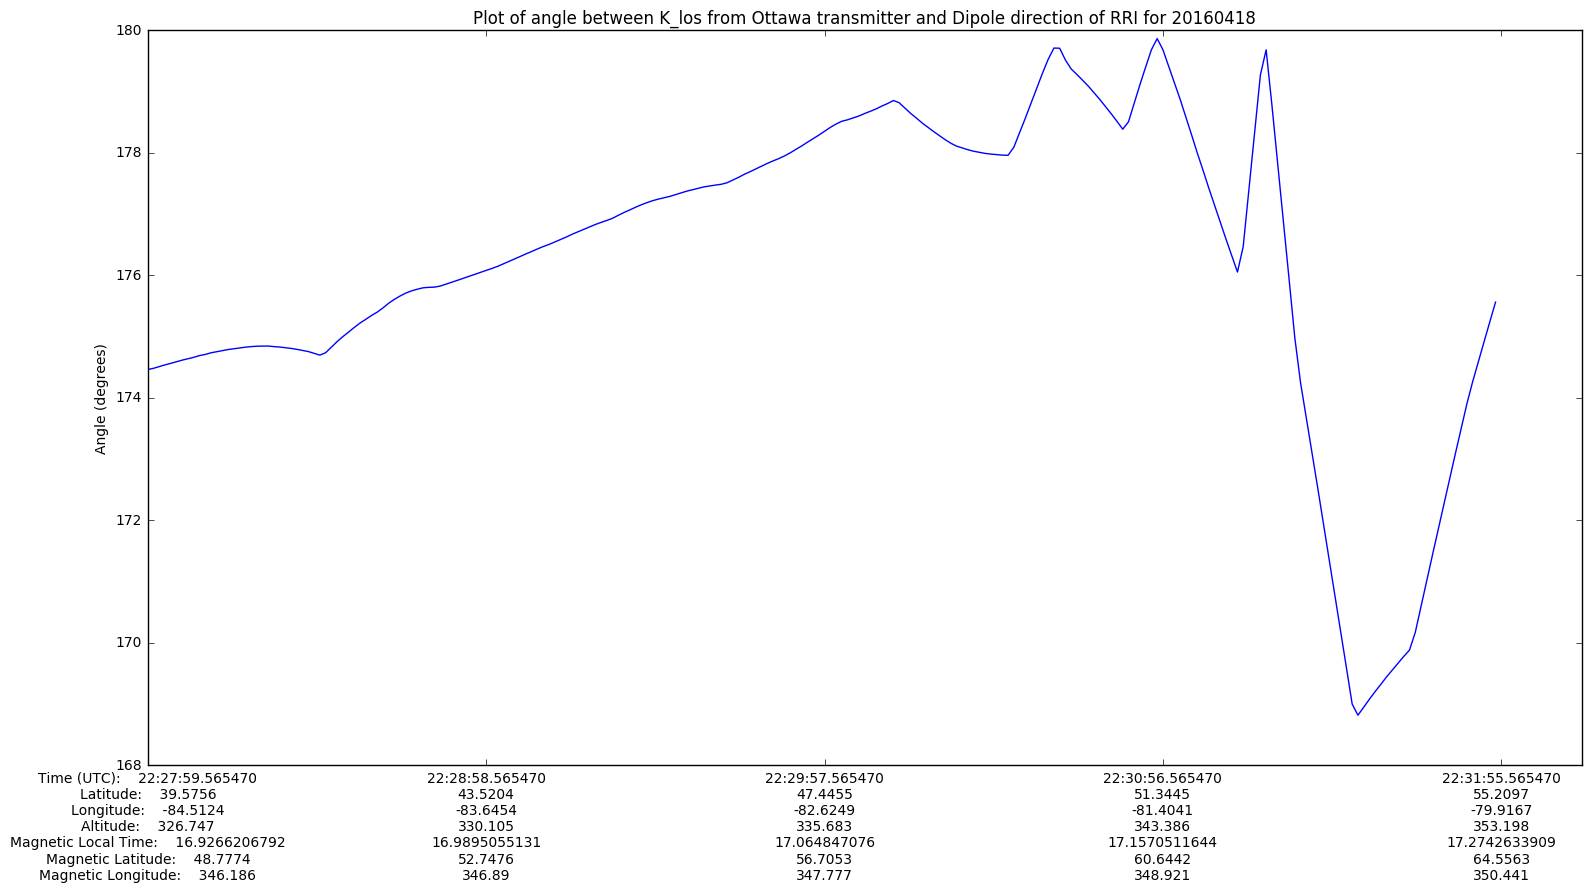

In [13]:
def plot_kdip_angle(date_string):
    """
    Plots the angle between the k_LOS vector and the dip_dir vector. 
    If they were perfectly matched, we would expect exactly 180 degrees.
    """
    fname,index_reversal = get_ottawa_data(date_string)
    lons,lats,alts,ephtimes,mlons,mlats,mlts,pitch,yaw,roll = get_rri_ephemeris_full(fname)
    dipole_dirs, kdip_angles = get_kdip_angles(lons,lats,alts,ephtimes,pitch,yaw,roll)
    #plot_kb_angle(date_string)
    #plot_kvec(date_string)
    #plot_ramdir("20160418")
    #fig = plt.figure()
    ax = plt.subplot(111)
    plt.subplots_adjust(bottom=0.2)
    plt.plot(kdip_angles)
    ephem_ticks(lons,lats,alts,ephtimes,mlons,mlats,mlts)
    plt.ylabel('Angle (degrees)')
    plt.title('Plot of angle between K_los from Ottawa transmitter and Dipole direction of RRI for ' + date_string)
    plt.show()
    
plot_kdip_angle("20160418")
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5,forward=True)

## Plotting Ram Directions from an RRI Dataset
Sometimes it's worth getting a view of the ram direction of CASSIOPE as it proceeds through its orbit and its orientation with respect to the magnetic field or ground stations changes.


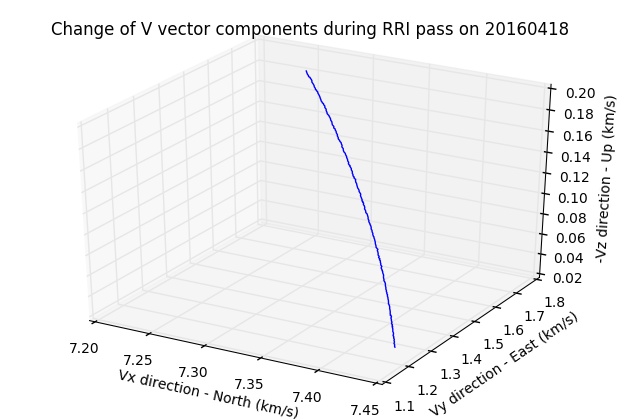

In [15]:
def plot_ramdir(date_string):
    """
    Makes a 3D plot of the ram direction components at each ephemeris point for
    the given date.  
    """
    datname,index_reversal = get_ottawa_data(date_string)
    lons,lats,alts,ephtimes,mlons,mlats,mlts,pitch,yaw,roll = get_rri_ephemeris_full(datname)
    vs,dists = get_ramdirs(lons,lats,alts,ephtimes)   
    indx_closest, dists = get_closest_ottawa_approach(lons,lats,alts)
    times = ephems_to_datetime(ephtimes)
    
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = Axes3D(fig)
    vx = [v[0] for v in vs]
    vy = [v[1] for v in vs]
    vz = [v[2] for v in vs]
    Axes3D.plot(ax,vx,vy,zs=vz)
    plt.xlabel("Vx direction - North (km/s)")
    plt.ylabel("Vy direction - East (km/s)")
    ax.set_zlabel("-Vz direction - Up (km/s)")
    plt.title("Change of V vector components during RRI pass on " + str(date_string))
    plt.show() 
    
plot_ramdir("20160418")

## Plotting K_los Vector
The line of sight vector from a nearby transmitter to the satellite gives a sense of what the radio wave's Poynting vector orientation would be, which is useful for analyzing its orientation with respect to the magnetic field of the Earth or its orientation with respect to the satellite itself.

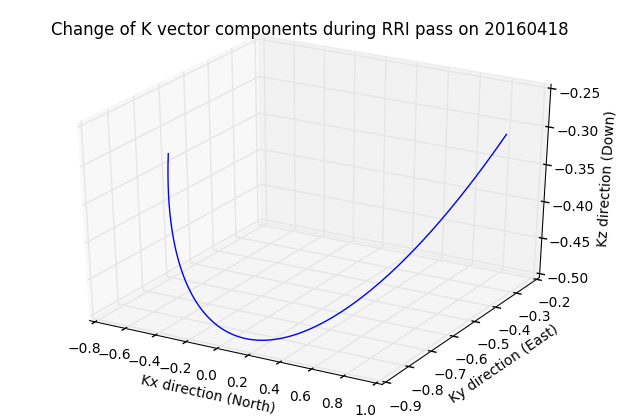

In [16]:
def plot_kvec(date_string):
    """
    A function for visualizing the k-vector's time evolution throughout a 
    pass of EPOP.

    *** PARAMS ***
    date_string (string): string in form "20160418" to denote date for which to plot KB angle

    *** RETURNS ***
    - (just plots)

    """
    fname,index_reversal = get_ottawa_data(date_string)
    lons,lats,alts,ephtimes,mlons,mlats,mlts,pitch,yaw,roll = get_rri_ephemeris_full(fname)
    bvecs,kvecs,angles = get_kb_ottawa_angle(lons,lats,alts,ephtimes)
    indx_closest, dists = get_closest_ottawa_approach(lons,lats,alts)
    times = ephems_to_datetime(ephtimes)
    
    my_xticks = []
    num_ticks = 5
    length = times.__len__()
    tick_sep = length/(num_ticks - 1)
    dt_t  = times[0]
    alt_t = alts[0]
    lon_t = lons[0]
    lat_t = lats[0]
    mlon_t = mlons[0]
    mlat_t = mlats[0]
    mlt_t = mlts[0]
    dist_t = dists[0]
    my_xticks.append("Time (UTC):    "+str(dt_t.time())+"\nLatitude:    "+str(lat_t)+\
        "\nLongitude:    "+str(lon_t)+"\nAltitude:    "+str(alt_t)+\
    "\nMagnetic Local Time:    "+str(mlt_t)+"\nMagnetic Latitude:    "+str(mlat_t)+\
    "\nMagnetic Longitude:    "+str(mlon_t)+"\nDistance (km):    "+str(dist_t))
    for i in range(num_ticks-1):
        alt_t = alts[tick_sep*(i+1)]
        lon_t = lons[tick_sep*(i+1)]
        lat_t = lats[tick_sep*(i+1)]
        mlon_t = mlons[tick_sep*(i+1)]
        mlat_t = mlats[tick_sep*(i+1)]
        dt_t  = times[tick_sep*(i+1)]
        mlt_t = mlts[tick_sep*(i+1)]
        dist_t = dists[tick_sep*(i+1)]
        my_xticks.append(str(dt_t.time())+"\n"+str(lat_t)+"\n"+str(lon_t)+"\n"+str(alt_t)+\
                "\n"+str(mlt_t)+"\n"+str(mlat_t)+"\n"+str(mlon_t)+"\n"+str(dist_t))
    
    indices = range(angles.__len__())
    tick_indices = [i*tick_sep for i in range(num_ticks)]
    
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = Axes3D(fig)
    kx = [kv[0] for kv in kvecs]
    ky = [kv[1] for kv in kvecs]
    kz = [kv[2] for kv in kvecs]
    Axes3D.plot(ax,kx,ky,zs=kz)
    plt.xlabel("Kx direction (North)")
    plt.ylabel("Ky direction (East)")
    ax.set_zlabel("Kz direction (Down)")
    plt.title("Change of K vector components during RRI pass on " + str(date_string))
    plt.show() 
    
plot_kvec("20160418")

## Plotting Estimated Aspect Angle
By taking the line of sight vector and comparing to the Earth's magnetic field orientation at various positions, the aspect angle of the wave as it passes through the density peak of the ionosphere can be inferred.

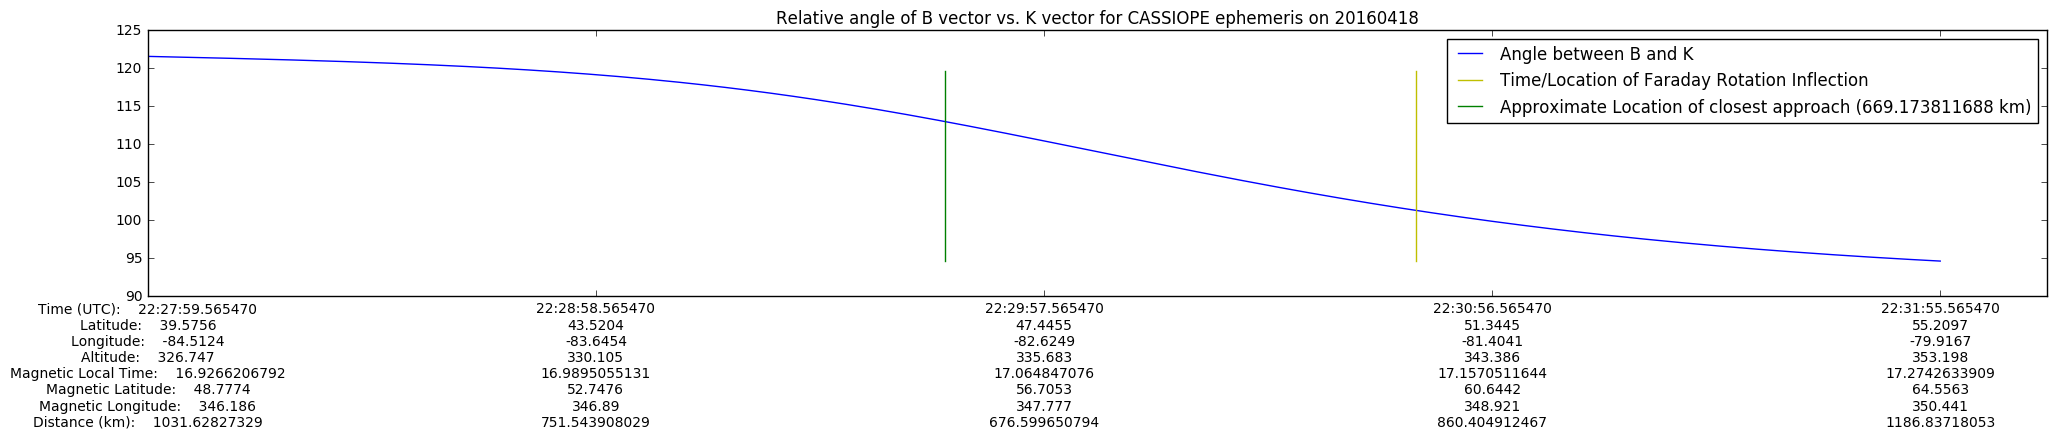

In [27]:
def plot_kb_angle(date_string):
    """
    Take date_string as input, produce kb-angle as output 

    *** PARAMS ***
    date_string (string): string in form "20160418" to denote date for which to plot KB angle

    *** RETURNS ***
    - (just plots)

    """
    fname,index_reversal = get_ottawa_data(date_string)
    lons,lats,alts,ephtimes,mlons,mlats,mlts,pitch,yaw,roll = get_rri_ephemeris_full(fname)
    bvecs,kvecs,angles = get_kb_ottawa_angle(lons,lats,alts,ephtimes)
    indx_closest, dists = get_closest_ottawa_approach(lons,lats,alts)
    times = ephems_to_datetime(ephtimes)
    
    my_xticks = []
    num_ticks = 5
    length = times.__len__()
    tick_sep = length/(num_ticks - 1)
    dt_t  = times[0]
    alt_t = alts[0]
    lon_t = lons[0]
    lat_t = lats[0]
    mlon_t = mlons[0]
    mlat_t = mlats[0]
    mlt_t = mlts[0]
    dist_t = dists[0]
    my_xticks.append("Time (UTC):    "+str(dt_t.time())+"\nLatitude:    "+str(lat_t)+\
        "\nLongitude:    "+str(lon_t)+"\nAltitude:    "+str(alt_t)+\
    "\nMagnetic Local Time:    "+str(mlt_t)+"\nMagnetic Latitude:    "+str(mlat_t)+\
    "\nMagnetic Longitude:    "+str(mlon_t)+"\nDistance (km):    "+str(dist_t))
    for i in range(num_ticks-1):
        alt_t = alts[tick_sep*(i+1)]
        lon_t = lons[tick_sep*(i+1)]
        lat_t = lats[tick_sep*(i+1)]
        mlon_t = mlons[tick_sep*(i+1)]
        mlat_t = mlats[tick_sep*(i+1)]
        dt_t  = times[tick_sep*(i+1)]
        mlt_t = mlts[tick_sep*(i+1)]
        dist_t = dists[tick_sep*(i+1)]
        my_xticks.append(str(dt_t.time())+"\n"+str(lat_t)+"\n"+str(lon_t)+"\n"+str(alt_t)+\
                "\n"+str(mlt_t)+"\n"+str(mlat_t)+"\n"+str(mlon_t)+"\n"+str(dist_t))
    
    indices = range(angles.__len__())
    tick_indices = [i*tick_sep for i in range(num_ticks)]
    
    # Formatting adjustment so as to make room for the lengthy Ephemeris info
    #fig = plt.figure()
    ax = plt.subplot(111,aspect = 'equal')
    plt.subplots_adjust(bottom=0.2)

    
    plt.plot(indices,angles,label="Angle between B and K")
    delta = int(max(angles) - min(angles))
    offs = min(angles)
    plt.plot((index_reversal)*np.ones(delta),offs+np.array(range(delta)),'y',label="Time/Location of Faraday Rotation Inflection")
    plt.plot((indx_closest)*np.ones(delta),offs+np.array(range(delta)),'g',label="Approximate Location of closest approach (" + str(dists[indx_closest]) + " km)")
    plt.title("Relative angle of B vector vs. K vector for CASSIOPE ephemeris on " + str(date_string))
    #plt.xlabel('Time elapsed during pass (seconds)')
    plt.xticks(tick_indices, my_xticks)
    plt.legend()
    plt.show()
    
plot_kb_angle("20160418")
fig = plt.gcf()
fig.set_size_inches(20.5, 6,forward=True)